In [1]:
import os
os.chdir('..')
metadata_path = 'big_data/metadata_20-04-03.csv'

In [2]:
import datetime
data_datetime = datetime.datetime(2020, 4, 5)

# Packages and presets

In [3]:
import gensim

# for preprocessing
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# for bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.stem.porter import *
import nltk

# nltk.download('wordnet')
from nltk.corpus import wordnet
from gensim import corpora, models
from pprint import pprint

# auxiliary
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)
import copy
# !date

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\vldoa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [23]:
import nlp.preprocessing as prep

dpi = 300 # figure resolution

# Load, preprocess data

In [5]:
df = pd.read_csv(metadata_path)
df = df[pd.isnull(df['abstract']) == False].reset_index(drop=True)

C:\Users\vldoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df[df['abstract'].str.lower().str.contains(
     "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome") | 
         df['abstract'].str.contains("MERS")
         ]

In [7]:
covid_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))).T[0]
df['abstract_COVID'] = df['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2')
mers_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('MER|middle east| Middle East'))).T[0]
sars_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('SARS'))).T[0]
df['abstract'] =df['abstract'].str.lower()
df['abstract'] = df['abstract'].str.replace('[^\w\s]','')
df.reset_index(drop=True, inplace=True)

In [8]:
count = sum(df['abstract_COVID'] )
count

2000

# NLP Gensim

**Notes**: Working LDA guide pulled from this website (https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24 ). Sklearn's LDA perplexity metric has a bug that makes it unusable.

## Data prep

In [9]:
# function to perform lemmatize and stem preprocessing steps on the data set.
preprocessor = prep.Preprocessor(df['abstract'])
preprocessor.preprocess(lemmatize=True, stopwords=['abstract'], min_token_length=3)

In [10]:
preprocessor.get_bigrams_from_preprocessed()

In [11]:
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)

0 canin_coronavirus
1 common
2 competit_elisa
3 describ
4 direct
5 epitop
6 felin
7 peplom_protein
8 relat
9 tgev_prcv
10 util

 126390 unique words. 

23526 unique words after extremes filtered. 


Word 16 ("coronavirus") appears 2 time.
Word 28 ("infect") appears 5 time.
Word 30 ("lead") appears 3 time.
Word 41 ("virus") appears 5 time.
Word 48 ("cell") appears 11 time.
Word 64 ("interact") appears 1 time.
Word 66 ("investig") appears 1 time.
Word 77 ("present") appears 1 time.
Word 81 ("result") appears 5 time.
Word 103 ("express") appears 3 time.
Word 111 ("observ") appears 1 time.
Word 142 ("protein") appears 5 time.
Word 158 ("genom") appears 1 time.
Word 165 ("murin_hepat") appears 1 time.
Word 177 ("specif") appears 1 time.
Word 207 ("short") appears 1 time.
Word 389 ("spike_protein") appears 1 time.
Word 502 ("inocul") appears 3 time.
Word 521 ("furthermor") appears 1 time.
Word 540 ("abl") appears 1 time.
Word 575 ("human") appears 5 time.
Word 642 ("rapid") appears 2 time.
W

## Topic model testing

In [12]:
bow_corpus_np = np.array(bow_corpus)

In [13]:
def cross_validate_topic_models(bow_corpus_np, dictionary, topic_range, n_splits):
    from gensim.models.coherencemodel import CoherenceModel
    # Cross-validate perplexity
    perplexities, coherences = [], []
    for n in topic_range:
        splits = np.random.choice(range(n_splits), size=len(bow_corpus_np))

        perplexities_n, coherences_n = [], []
        print(n)
        for s in range(n_splits):
            training = bow_corpus_np[np.argwhere(splits != s).T[0]]
            test = bow_corpus_np[np.argwhere(splits == s).T[0]]

            lda_model = gensim.models.LdaMulticore(
                            training, num_topics=n,
                            id2word=dictionary, passes=2
                        )
            
            perplexity = lda_model.log_perplexity(test)
            cm = CoherenceModel(model=lda_model, texts=test, dictionary=dictionary, coherence='c_v')
            coherence = cm.get_coherence()

            perplexities_n.append(perplexity); coherences_n.append(coherence)
            print('-')
            
        perplexities.append(perplexities_n); coherences.append(coherences_n)
        print('Perplexities: ' + str(np.mean(perplexities_n)) + ' +/- ' + 
              str(np.std(perplexities_n) / n_splits ** 0.5))
        print('Coherences: ' + str(np.mean(coherences_n)) + ' +/- ' + 
              str(np.std(coherences_n) / n_splits ** 0.5))

    return np.array(perplexities), np.array(coherences)

In [244]:
min_topics = 5
max_topics = 100
step = 10
topic_range = range(min_topics, max_topics, step)

In [245]:
perplexities2, coherences2 = cross_validate_topic_models(bow_corpus_np=bow_corpus_np,
                                     dictionary=dictionary,
                                     topic_range=topic_range,
                                     n_splits=5
                                    )

5


/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


-
-


KeyboardInterrupt: 

In [16]:
def plot_error_bounded_scores(scores, x):
    mean = np.mean(scores, axis=1)
    stdev = np.std(scores, axis=1) / (scores.shape[1] * 0.5)
    mean_plus = mean + stdev; mean_minus = mean - stdev
    n_topics_index = np.array(list(range(len(mean)))) + 1

    fig, ax = plt.subplots()
    ax.plot(x, mean)
    ax.plot(x, mean_plus, c='black')
    ax.plot(x, mean_minus, c='black')


    ax.plot([min_topics, max_topics], [max(mean), min(mean)])
    return mean, stdev, fig, ax

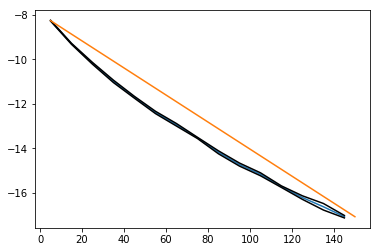

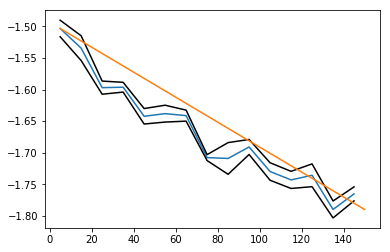

In [20]:
# Num of Topic ranging from 2 to 10
_, _, fig, ax = plot_error_bounded_scores(perplexities2, topic_range)
plt.show()

_, _, fig, ax = plot_error_bounded_scores(coherences2, topic_range)
plt.show()

## Topic model fitting

In [13]:
np.random.seed(25)

n_topics = 30

lda_model = gensim.models.LdaMulticore(
                bow_corpus_np, num_topics=n_topics,
                id2word=dictionary, passes=2, workers=4, eval_every=1
            )

In [14]:
topic_words = []
n_top_words = 10

for i in range(n_topics):
    tt = lda_model.get_topic_terms(i,n_top_words)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    
for e, i in enumerate(topic_words):
    print()
    print(i)
lda_model.print_topics(num_words=n_top_words)


['patient', 'infect', 'coronavirus', 'covid', 'virus', 'diseas', 'case', 'sever', 'studi', 'report']

['outbreak', 'coronavirus', 'studi', 'virus', 'case', 'sarscov', 'respiratori_syndrom', 'sar', 'assay', 'posit']

['case', 'sarscov', 'coronavirus', 'infect', 'diseas', 'human', 'sar', 'covid', 'patient', 'outbreak']

['infect', 'covid', 'virus', 'studi', 'sarscov', 'case', 'patient', 'diseas', 'day', 'result']

['virus', 'detect', 'coronavirus', 'sar', 'respiratori', 'assay', 'patient', 'sequenc', 'differ', 'infect']

['virus', 'coronavirus', 'infect', 'viral', 'sar', 'protein', 'gene', 'diseas', 'studi', 'sequenc']

['coronavirus', 'merscov', 'vaccin', 'emerg', 'respiratori_syndrom', 'diseas', 'infect', 'studi', 'sar', 'outbreak']

['infect', 'virus', 'cell', 'coronavirus', 'viral', 'strain', 'ncov', 'protein', 'express', 'human']

['protein', 'coronavirus', 'sarscov', 'virus', 'activ', 'respiratori_syndrom', 'studi', 'structur', 'human', 'sever_acut']

['merscov', 'infect', 'corona

[(2,
  '0.028*"case" + 0.023*"sarscov" + 0.014*"coronavirus" + 0.012*"infect" + 0.012*"diseas" + 0.011*"human" + 0.010*"sar" + 0.009*"covid" + 0.009*"patient" + 0.008*"outbreak"'),
 (20,
  '0.019*"virus" + 0.017*"infect" + 0.015*"coronavirus" + 0.014*"sarscov" + 0.012*"viral" + 0.008*"effect" + 0.007*"protein" + 0.007*"outbreak" + 0.007*"respiratori_syndrom" + 0.006*"case"'),
 (7,
  '0.033*"infect" + 0.026*"virus" + 0.018*"cell" + 0.013*"coronavirus" + 0.013*"viral" + 0.011*"strain" + 0.009*"ncov" + 0.009*"protein" + 0.008*"express" + 0.008*"human"'),
 (14,
  '0.019*"infect" + 0.016*"coronavirus" + 0.011*"outbreak" + 0.011*"virus" + 0.010*"studi" + 0.009*"sarscov" + 0.008*"case" + 0.008*"includ" + 0.007*"control" + 0.007*"identifi"'),
 (16,
  '0.034*"sarscov" + 0.029*"virus" + 0.020*"infect" + 0.020*"coronavirus" + 0.018*"diseas" + 0.010*"viral" + 0.009*"human" + 0.009*"covid" + 0.008*"epidem" + 0.007*"patient"'),
 (29,
  '0.011*"patient" + 0.011*"virus" + 0.009*"viral" + 0.009*"sar" +

 # Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [15]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_np, texts=df['abstract']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_np, texts=df['abstract'])

# Format
dominant_topic_30 = df_topic_sents_keywords.reset_index()
dominant_topic_30.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']

# Show
dominant_topic_30

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract
0,0,23.0,0.4329,"sar, virus, vaccin, infect, coronavirus, patie...",abstract a competition elisa utilizing a mab d...
1,1,16.0,0.9764,"sarscov, virus, infect, coronavirus, diseas, v...",abstract the causative agent of the respirator...
2,2,7.0,0.9076,"infect, virus, cell, coronavirus, viral, strai...",abstract the morphology and morphogenesis of v...
3,3,7.0,0.6497,"infect, virus, cell, coronavirus, viral, strai...",abstract expression of bovine coronavirus bcv ...
...,...,...,...,...,...
9955,9955,9.0,0.6823,"merscov, infect, coronavirus, human, virus, mi...",a novel coronavirus has caused thousands of hu...
9956,9956,13.0,0.5772,"virus, outbreak, sar, infect, coronavirus, vac...",abstract bats are the natural reservoirs of se...
9957,9957,5.0,0.6234,"virus, coronavirus, infect, viral, sar, protei...",abstract this paper combines two advances to d...
9958,9958,19.0,0.9901,"infect, detect, sampl, studi, cell, result, di...",abstract feline and canine coronaviruses fcov ...


In [16]:
dominant_topic_30['abstract_COVID'] = df['abstract_COVID']
dominant_topic_30['abstract_COVID'] = dominant_topic_30['abstract_COVID'].astype(int)

In [17]:
sum(dominant_topic_30['abstract_COVID'])

2000

In [18]:
dominant_topic_30

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract,abstract_COVID
0,0,23.0,0.4329,"sar, virus, vaccin, infect, coronavirus, patie...",abstract a competition elisa utilizing a mab d...,0
1,1,16.0,0.9764,"sarscov, virus, infect, coronavirus, diseas, v...",abstract the causative agent of the respirator...,0
2,2,7.0,0.9076,"infect, virus, cell, coronavirus, viral, strai...",abstract the morphology and morphogenesis of v...,0
3,3,7.0,0.6497,"infect, virus, cell, coronavirus, viral, strai...",abstract expression of bovine coronavirus bcv ...,0
...,...,...,...,...,...,...
9955,9955,9.0,0.6823,"merscov, infect, coronavirus, human, virus, mi...",a novel coronavirus has caused thousands of hu...,0
9956,9956,13.0,0.5772,"virus, outbreak, sar, infect, coronavirus, vac...",abstract bats are the natural reservoirs of se...,0
9957,9957,5.0,0.6234,"virus, coronavirus, infect, viral, sar, protei...",abstract this paper combines two advances to d...,0
9958,9958,19.0,0.9901,"infect, detect, sampl, studi, cell, result, di...",abstract feline and canine coronaviruses fcov ...,0


# Output file 

In [22]:
dominant_topic_30.to_csv("big_data/dominant_topic_30.csv")

# Visualizations

In [19]:
metadata_dt_analysis = copy.deepcopy(df)
metadata_dt_analysis['Dominant_Topic'] = dominant_topic_30['Dominant_Topic']
metadata_dt_analysis['Dominant_Topic'] = metadata_dt_analysis['Dominant_Topic'].astype(int)
print(len(metadata_dt_analysis))


metadata_dt_analysis['converted_datetime'] = pd.to_datetime(metadata_dt_analysis['publish_time'], errors='coerce') # if format fails to parse, return NaT
metadata_dt_analysis = metadata_dt_analysis.sort_values('converted_datetime')
metadata_dt_analysis = metadata_dt_analysis[pd.isnull(metadata_dt_analysis['converted_datetime']) == False] # drop abstracts w/ null
metadata_dt_analysis = metadata_dt_analysis[metadata_dt_analysis['converted_datetime'] <= data_datetime] # 
print(len(metadata_dt_analysis))

9959
9891


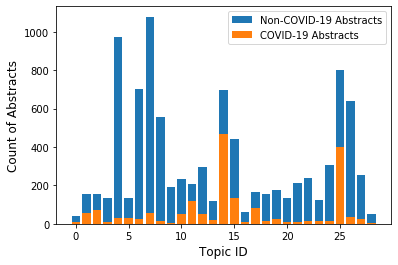

In [31]:
fig, ax = plt.subplots()
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])),
        np.bincount(metadata_dt_analysis['Dominant_Topic'], minlength=max(metadata_dt_analysis['Dominant_Topic']))[1:], 
        label='Non-COVID-19 Abstracts')
subset_COVID = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset_COVID['Dominant_Topic'])),
        np.bincount(subset_COVID['Dominant_Topic'], minlength=max(subset_COVID['Dominant_Topic']))[1:], 
        label='COVID-19 Abstracts')
plt.xlabel('Topic ID', size=12)
plt.ylabel('Count of Abstracts', size=12)
# plt.title('Distribution of Abstracts Across Topics', size=14)
fig.savefig('Paper/Figures/6.png', dpi=dpi)
plt.legend()

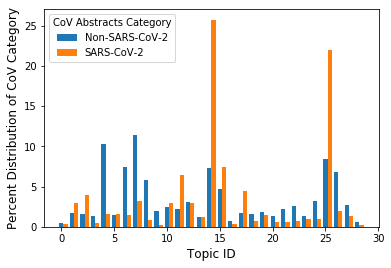

In [32]:
abstract_cnts = np.bincount(metadata_dt_analysis['Dominant_Topic'],
                    minlength=max(metadata_dt_analysis['Dominant_Topic']))[1:]
abstract_cnts = abstract_cnts / sum(abstract_cnts) * 100

fig, ax = plt.subplots()
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])),
        abstract_cnts, 
        label='Non-SARS-CoV-2', width=0.4)

abstract_cnts = np.bincount(subset_COVID['Dominant_Topic'], minlength=max(subset_COVID['Dominant_Topic']))[1:]
abstract_cnts = abstract_cnts / sum(abstract_cnts) * 100
subset_COVID = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset_COVID['Dominant_Topic'])) + .4,
        abstract_cnts, 
        label='SARS-CoV-2', width=0.4)
plt.xlabel('Topic ID', size=12)
plt.ylabel('Percent Distribution of CoV Category', size=12)
# plt.title('Distribution of Abstracts Across Topics', size=14)
plt.legend(title='CoV Abstracts Category')
# fig.savefig('Paper/Figures/6.png', dpi=dpi)
plt.show()

In [37]:
subset_COVID = metadata_dt_analysis[
    metadata_dt_analysis['abstract_COVID'] &
    (subset_COVID['converted_datetime'] > datetime.datetime(2020, 1, 1))]

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
topics, c = np.unique(subset_COVID['Dominant_Topic'], return_counts=True)
topics = topics[np.argsort(c)[::-1]]; c = c[np.argsort(c)[::-1]]

n_major = 2
major_topics = topics[0:n_major]

(array([737456., 737470., 737485., 737499., 737516.]),
 <a list of 5 Text xticklabel objects>)

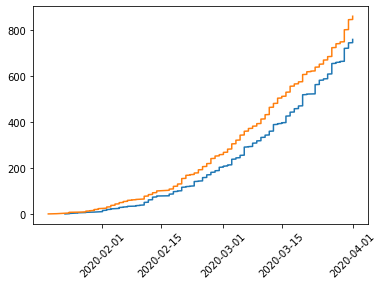

In [39]:

boolean_major_topics = subset_COVID['Dominant_Topic'].isin(major_topics)

y = np.arange(1, sum(boolean_major_topics) + 1)
plt.plot(subset_COVID[boolean_major_topics]['converted_datetime'], y)

y = np.arange(1, sum(boolean_major_topics == False) + 1)
plt.plot(subset_COVID[boolean_major_topics==False]['converted_datetime'], y)
plt.xticks(rotation=45)

# plt.yscale('log')

Biomolecular; other
3, 5, 7, 8, 10, 17
Biomolecular; anti-viral work
16, 22 , 23
Clinical studies
0, 18, 26
Interaction with non-human species
4, 21, 24
Outbreaks
2, 13, 14, 20
Responding to outbreaks
11, 12, 15
Viral detection
19, 25, 27
Other
1, 6, 9, 28, 29

In [40]:
t_biomolecular_other = [3, 5, 7, 8, 10, 17]
t_biomolecular_antiviral = [16, 22 , 23]
t_clinical = [0, 18, 26]
t_non_human = [4, 21, 24]
# t_responding = []
t_outbreaks = [11, 12, 15, 2, 13, 14, 20]
t_detection = [19, 25, 27]
t_other = [1, 6, 9, 28, 29]

t_all = [t_biomolecular_other, t_biomolecular_antiviral, t_clinical, t_non_human,
         t_outbreaks, t_detection, t_other]
t_all_names = ['Biomolecular, general', 'Biomolecular, antiviral', 'Patients & healthcare services', 
               'Non-human species', 'Outbreak & response', 'Viral detection', 'Other']

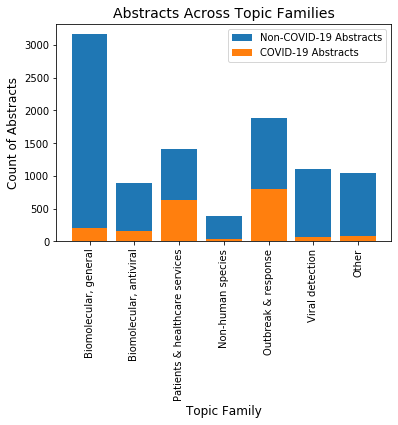

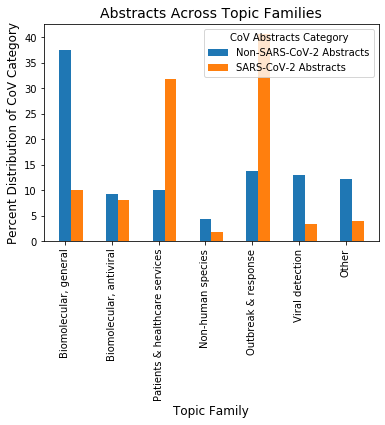

In [41]:
sums_all, sums_covid = [], []
for t, lst in enumerate(t_all):
    boolean = metadata_dt_analysis['Dominant_Topic'].isin(lst)
    sums_all.append(sum(boolean))
    boolean = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    
plt.bar(np.arange(0, len(t_all)),
        sums_all, 
        label='Non-COVID-19 Abstracts')
plt.bar(np.arange(0, len(t_all)),
        sums_covid, 
        label='COVID-19 Abstracts')
plt.xticks(np.arange(len(t_all)), t_all_names, rotation=90)
plt.ylabel('Count of Abstracts', size=12)
plt.xlabel('Topic Family', size=12)
plt.title('Abstracts Across Topic Families', size=14)
plt.legend()
plt.show()


## By percentage
sums_all, sums_covid = [], []
for t, lst in enumerate(t_all):
    boolean = metadata_dt_analysis['Dominant_Topic'].isin(lst)
    sums_all.append(sum(boolean))
    boolean = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    
sums_all = np.array(sums_all)
sums_covid = np.array(sums_covid)
    
sums_all = sums_all - sums_covid # get non-COVID only
sums_covid = np.array(sums_covid) * 100 / sum(sums_covid)
sums_all = np.array(sums_all) * 100 / sum(sums_all)

    
plt.bar(np.arange(0, len(t_all)),
        sums_all, 
        label='Non-SARS-CoV-2 Abstracts', width=0.25)
plt.bar(np.arange(0, len(t_all)) + 0.25,
        sums_covid, 
        label='SARS-CoV-2 Abstracts', width=0.25)
plt.xticks(np.arange(len(t_all)), t_all_names, rotation=90)
plt.ylabel('Percent Distribution of CoV Category', size=12)
plt.xlabel('Topic Family', size=12)
plt.title('Abstracts Across Topic Families', size=14)
plt.legend(title='CoV Abstracts Category')
plt.show()

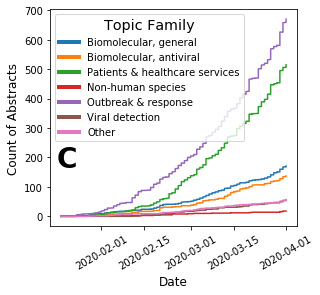

In [56]:
sums_all, sums_covid = [], []
fig, ax = plt.subplots(figsize=(4.43, 4.43))
for t, lst in enumerate(t_all):
    boolean = subset_COVID['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    plt.plot(subset_COVID['converted_datetime'], np.cumsum(boolean), label = t_all_names[t])
plt.xticks(rotation=30)

leg = ax.legend(title='Topic Family')
plt.setp(leg.get_title(),fontsize='x-large')
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(4)
    
plt.ylabel('Count of Abstracts', size=12)
plt.xlabel('Date', size=12)
plt.text(0.025, 0.375, 'C', transform=ax.transAxes, fontsize=28, fontweight='bold', va='top')
# plt.title('Topic Families Over Time in COVID-19 Abstracts', size=14)
# plt.yscale('log')
plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('Paper/Figures/7c.png', dpi=dpi)

In [ ]:
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])),
        np.bincount(metadata_dt_analysis['Dominant_Topic'], minlength=max(metadata_dt_analysis['Dominant_Topic']))[1:], 
        label='Non-COVID-19 Abstracts')
subset = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset['Dominant_Topic'])),
        np.bincount(subset['Dominant_Topic'], minlength=max(subset['Dominant_Topic']))[1:], 
        label='COVID-19 Abstracts')
plt.xlabel('Topic ID', size=12)
plt.ylabel('Count of Abstracts', size=12)
plt.title('Distribution of Abstracts Across Topics', size=14)
plt.legend()

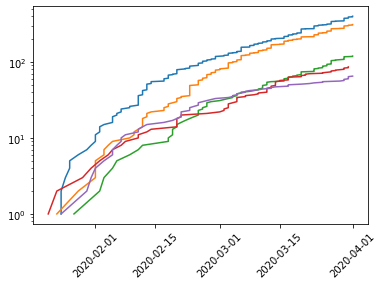

In [97]:
major_topics_n = topics[0:5]
labels = [
    'Public health management',
    'Clinical manifestations',
    'Clinical studies',
    '',
    '',
]

for t in major_topics_n:
    boolean = (subset_COVID['Dominant_Topic'] == t)
    y = np.arange(1, sum(boolean) + 1)
    plt.plot(subset_COVID[boolean]['converted_datetime'], y)

plt.xticks(rotation=45)

plt.yscale('log')

plt.xlabel('Date', size=12)
plt.ylabel('Count of Abstracts (log scale)', size=12)
plt.title('Abstracts Over Time', size=14)
plt.legend()

# COVID Distribution

In [50]:
topics_distribution = dominant_topic_30.groupby(['Dominant_Topic']).agg({'abstract_COVID': 'sum'})

# topic_COVID_presentage = topics_distribution.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.count()))
topic_tot = dominant_topic_30.groupby(['Dominant_Topic']).agg({'abstract_COVID': 'count'})

In [51]:
covid_distribution = pd.merge(topics_distribution,topic_tot, on = "Dominant_Topic")

In [52]:
covid_distribution['COVID_Percentage'] = covid_distribution['abstract_COVID_x']/covid_distribution['abstract_COVID_y']

In [53]:
covid_distribution

,abstract_COVID_x,abstract_COVID_y,COVID_Percentage
Dominant_Topic,,,
0.0,150,458,0.327511
1.0,6,43,0.139535
2.0,56,160,0.350000
3.0,75,160,0.468750
...,...,...,...
26.0,407,815,0.499387
27.0,35,640,0.054688
28.0,24,254,0.094488
29.0,5,55,0.090909


In [54]:
covid_distribution.rename(columns={"abstract_COVID_x": "abstract_COVID", "abstract_COVID_y": "total"})

,abstract_COVID,total,COVID_Percentage
Dominant_Topic,,,
0.0,150,458,0.327511
1.0,6,43,0.139535
2.0,56,160,0.350000
3.0,75,160,0.468750
...,...,...,...
26.0,407,815,0.499387
27.0,35,640,0.054688
28.0,24,254,0.094488
29.0,5,55,0.090909


In [55]:
covid_distribution.to_csv("big_data/covid_distribution_30.csv")